In [2]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm_notebook
import tqdm


from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [4]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user = nn.Embedding(nb_users, mf_dim)
        self.mf_item = nn.Embedding(nb_items, mf_dim)

        size = mlp_layer_sizes[0] // 2
        self.mlp_user = nn.Embedding(nb_users, size)
        self.mlp_item = nn.Embedding(nb_items, size)

        self.dropout = dropout

        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])\
                                  for i in range(1,nb_mlp_layers)])
        self.last = nn.Linear(mlp_layer_sizes[-1]+mf_dim, 1)     
        

        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)

        #YOUR TASK: Initialze weights ~4 lines of code - use glorot (final MLP has to use lecunn

        self.mf_user.weight.data.normal_(0., 0.01)
        self.mf_item.weight.data.normal_(0., 0.01)
        self.mlp_user.weight.data.normal_(0., 0.01)
        self.mlp_item.weight.data.normal_(0., 0.01)

        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.last)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        mf_user =  self.mf_user(user)
        mf_item =  self.mf_item(item)
        mf = mf_user * mf_item

        mlp_user = self.mlp_user(user)
        mlp_item = self.mlp_item(item)
        mlp = torch.cat((mlp_user, mlp_item), dim=1)
        for i,layer in enumerate(self.mlp):
            mlp = layer(mlp)
            mlp = nn.functional.relu(mlp)
            if self.dropout != 0:
                mlp = nn.functional.dropout(mlp, p=self.dropout, training=self.training)

        x = torch.cat((mf,mlp), dim=1)
        x = self.last(x)
        if sigmoid:
            x = torch.sigmoid(x)

        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [5]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        #Sample neg users
        user,item=0,1
        neg_users = ratings[:,user].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,user], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,item])
        neg_items = neg_items.repeat(self.negative_samples)
        neg_items = neg_items.random_(0,max_item)
        self.items = torch.cat((ratings[:,item], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,item], dtype=torch.float32)
        neg_label = neg_label.repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,item], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [ ]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code

users_num = 944
movies_num = 1683

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)

test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

cross_val_num = 3
iter_num = 40

total_length = len(ds_train)
subset_sizes = [total_length // cross_val_num] * cross_val_num
subset_sizes[-1] += total_length % cross_val_num

subset_datasets = random_split(ds_train, subset_sizes)

params = {
    'mf_dim': [24, 16],
    'mlp_layer_sizes': [[128, 64], [128, 64, 32]],
    'learning_rate': [0.01, 0.001],
    'dropout': [0.3, 0.6]
}
tot_iter = 0
max_iter = iter_num * cross_val_num
for val in params.values():
    max_iter *= len(val)

results = pd.DataFrame()
for mf_dim in params['mf_dim']:
    for mlp_layer_sizes in params['mlp_layer_sizes']:
        for learning_rate in params['learning_rate']:
            for dropout in params['dropout']:
                cv_loss = []
                for k in range(cross_val_num):

                    train_dl = DataLoader(subset_datasets[k], batch_size=16*1024, shuffle=True)
                    
                    model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes, dropout)
                    criterion = nn.BCELoss()
                    optimizer = Adam(model.parameters(), lr= learning_rate)
                    test_loss = []
                    train_loss = []

                    for epoch in range(iter_num):
                        model.train()
                        ep_train_loss=[]
                        print(f"Epoch {epoch} Total {tot_iter}/{max_iter}")
                        for (u,i,l) in tqdm.tqdm(train_dl):
                            optimizer.zero_grad()
                            y_hat = model(u,i,sigmoid=True)
                            l = l.unsqueeze(1)
                            loss = criterion(y_hat, l)
                            ep_train_loss.append(loss.detach().numpy())
                            loss.backward()
                            optimizer.step()
                        train_loss.append(np.mean(ep_train_loss))
                        preds = []
                        ep_test_loss=[]
                        with torch.no_grad():
                            model.eval()
                            for i, (u,i,l) in enumerate(test_dl):
                                y_hat = model(u, i, sigmoid=True)
                                preds.append(y_hat)
                                l = l.unsqueeze(1)
                                tl = criterion(y_hat, l)
                                ep_test_loss.append(tl) 
                            test_loss.append(np.mean(ep_test_loss))
                        tot_iter += 1

                    cv_loss.append(test_loss)
                cv_loss_mean = np.mean(cv_loss)

                current_run = pd.DataFrame.from_dict({'mf_dim' : [mf_dim],
                                                      'mlp_layer_sizes' : [mlp_layer_sizes], 
                                                      'learning_rate' : [learning_rate],
                                                      'dropout' : [dropout],
                                                      'loss' : [cv_loss_mean],
                                                      'loss_ep' : [{
                                                                    'train' : train_loss,
                                                                    'test'  : test_loss,
                                                                    }]
                                                      })
                
                results = pd.concat([results, current_run])

In [35]:
results = results.reset_index()
results.sort_values("loss")

,index,mf_dim,mlp_layer_sizes,learning_rate,dropout,loss,loss_ep
10,0,16,"[128, 64]",0.001,0.3,0.526172,"{'train': [0.69782925, 0.68369454, 0.6678506, ..."
2,0,24,"[128, 64]",0.001,0.3,0.527601,"{'train': [0.69350535, 0.67997694, 0.66370845,..."
11,0,16,"[128, 64]",0.001,0.6,0.527628,"{'train': [0.6758605, 0.66647536, 0.6557247, 0..."
3,0,24,"[128, 64]",0.001,0.6,0.528626,"{'train': [0.6934568, 0.68336046, 0.67238253, ..."
6,0,24,"[128, 64, 32]",0.001,0.3,0.529410,"{'train': [0.68959874, 0.681145, 0.67120284, 0..."
7,0,24,"[128, 64, 32]",0.001,0.6,0.529576,"{'train': [0.69458824, 0.6864336, 0.6772417, 0..."
14,0,16,"[128, 64, 32]",0.001,0.3,0.531467,"{'train': [0.71765786, 0.70608443, 0.6945315, ..."
15,0,16,"[128, 64, 32]",0.001,0.6,0.532404,"{'train': [0.6779201, 0.67082065, 0.6637454, 0..."
9,0,16,"[128, 64]",0.010,0.6,0.747761,"{'train': [0.68461835, 0.5612425, 0.51270354, ..."
8,0,16,"[128, 64]",0.010,0.3,0.764314,"{'train': [0.65119004, 0.53640944, 0.49965802,..."


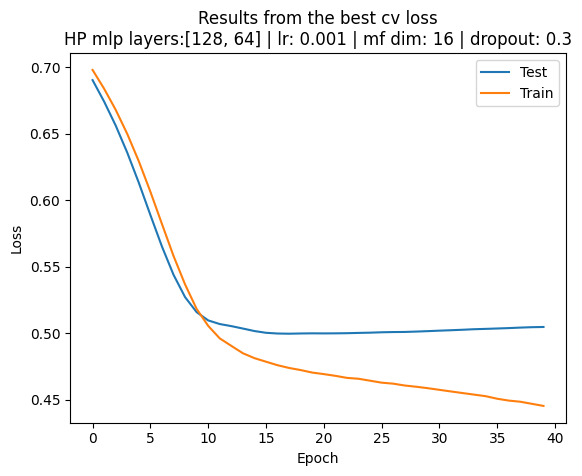

In [45]:
plt.plot(results["loss_ep"].loc[10]["test"], label = "Test")
plt.plot(results["loss_ep"].loc[10]["train"], label = "Train")
best = results.loc[10]
hp_string = f'mlp layers:{best["mlp_layer_sizes"]} | lr: {best["learning_rate"]} | mf dim: {best["mf_dim"]} | dropout: {best["dropout"]}'
plt.title("Results from the best cv loss\nHP " + hp_string)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()